In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime
from matplotlib.colors import ListedColormap
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [5]:
# ## 1. Data Collection

# %%
def fetch_weather_data(latitude='51.5074', longitude='-0.1278'):
    """Fetch weather data from Open-Meteo API"""
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'current_weather': 'true',
        'hourly': 'temperature_2m,relativehumidity_2m,windspeed_10m'
    }
    try:
        response = requests.get("https://api.open-meteo.com/v1/forecast", params=params)
        if response.status_code == 200:
            return response.json()
    except Exception as e:
        print(f"Error fetching weather data: {e}")
    return None
# Fetch data
raw_data = fetch_weather_data()
if not raw_data:
    raise ValueError("Failed to fetch weather data")


In [7]:
# ## 2. Data Transformation

# %%
def transform_weather_data(weather_data):
    """Transform raw API data into analysis-ready format"""
    current = weather_data['current_weather']
    hourly = weather_data.get('hourly', {})
    
    return {
        'latitude': float(weather_data['latitude']),
        'longitude': float(weather_data['longitude']),
        'temperature': current['temperature'],
        'windspeed': current['windspeed'],
        'winddirection': current['winddirection'],
        'weathercode': current['weathercode'],
        'hourly_temperatures': hourly.get('temperature_2m', []),
        'hourly_humidity': hourly.get('relativehumidity_2m', []),
        'hourly_windspeeds': hourly.get('windspeed_10m', []),
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

weather_data = transform_weather_data(raw_data)


In [8]:
# ## 3. Synthetic Data Generation
# 
# Since we need multiple data points for clustering, we'll generate synthetic data based on the real measurements.

# %%
def generate_weather_samples(real_data, num_samples=100):
    """Generate synthetic weather data based on real measurements"""
    # Create variance based on hourly patterns
    temp_range = np.ptp(real_data['hourly_temperatures']) if real_data['hourly_temperatures'] else 5
    wind_range = np.ptp(real_data['hourly_windspeeds']) if real_data['hourly_windspeeds'] else 3
    
    return pd.DataFrame({
        'latitude': np.random.normal(real_data['latitude'], 0.1, num_samples),
        'longitude': np.random.normal(real_data['longitude'], 0.1, num_samples),
        'temperature': np.random.normal(real_data['temperature'], temp_range/3, num_samples),
        'windspeed': np.abs(np.random.normal(real_data['windspeed'], wind_range/3, num_samples)),
        'winddirection': (real_data['winddirection'] + np.random.uniform(-45, 45, num_samples)) % 360,
        'weathercode': [real_data['weathercode']] * num_samples
    })

df = generate_weather_samples(weather_data)
df.head()

,latitude,longitude,temperature,windspeed,winddirection,weathercode
0,51.411570,-0.191658,18.966035,18.481376,213.803937,3
1,51.523382,-0.092904,13.111885,17.212174,294.179400,3
2,51.442035,-0.073485,17.340711,28.003390,223.436253,3
3,51.513204,-0.108290,16.626048,11.204194,237.092130,3
4,51.533717,-0.236142,15.441235,18.997310,255.633361,3


In [10]:
# ## 4. Feature Engineering

# %%
# Convert wind direction to x,y components for better clustering
df['wind_x'] = np.sin(np.radians(df['winddirection']))
df['wind_y'] = np.cos(np.radians(df['winddirection']))

features = df[['temperature', 'windspeed', 'wind_x', 'wind_y']]

In [11]:
# ## 5. Dimensionality Reduction with PCA

# %%
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.66872921 0.32777252]


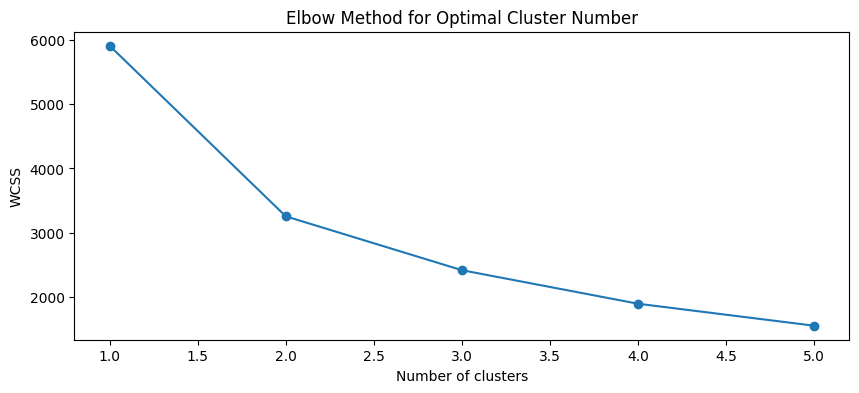

In [12]:
# ## 6. K-Means Clustering

# %%
# Determine optimal clusters using elbow method
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(range(1, 6), wcss, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [13]:
# Final clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)
df_pca['cluster'] = df['cluster']


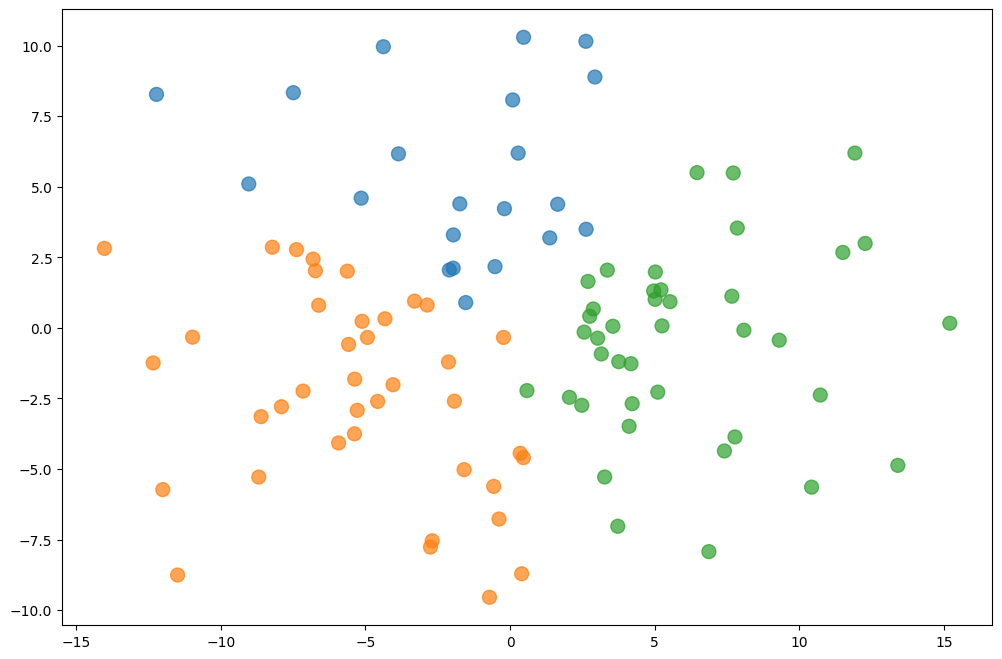

In [14]:
# ## 7. Visualization & Interpretation

# %%
# Weather code descriptions
weather_code_map = {
    0: "Clear sky", 1: "Mainly clear", 2: "Partly cloudy", 3: "Overcast",
    45: "Fog", 48: "Rime fog", 51: "Light drizzle", 53: "Moderate drizzle",
    61: "Slight rain", 63: "Moderate rain", 65: "Heavy rain"
}

plt.figure(figsize=(12, 8))
cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

scatter = plt.scatter(
    df_pca['PC1'], 
    df_pca['PC2'], 
    c=df_pca['cluster'], 
    cmap=cmap,
    s=100,
    alpha=0.7
)

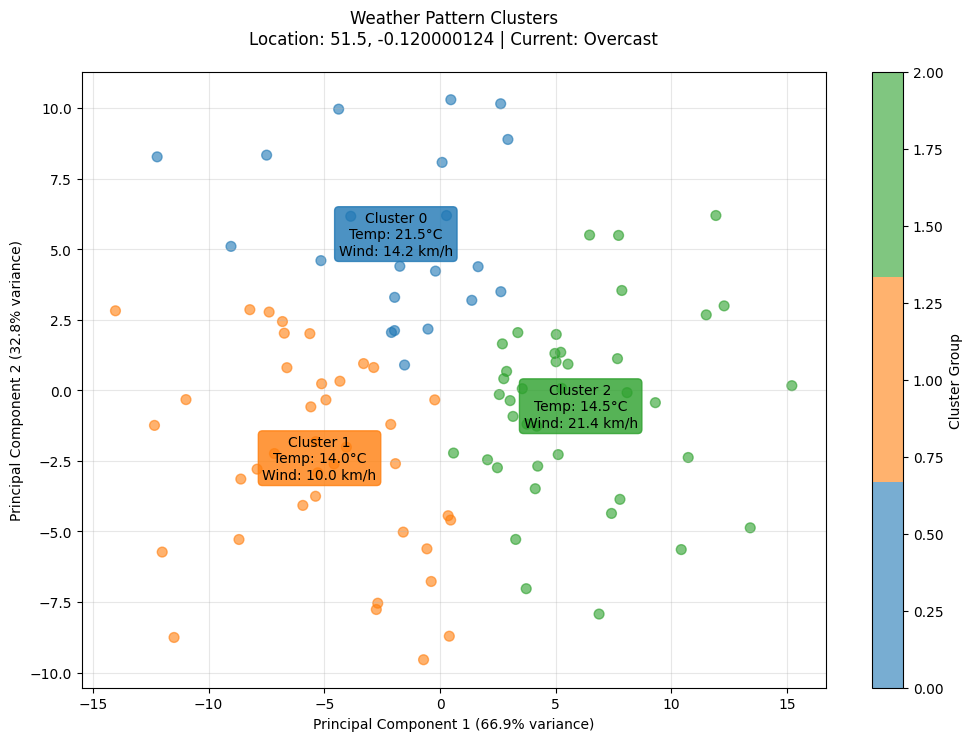

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))  # Explicit figure and axes

# Scatter plot
scatter = ax.scatter(
    df_pca['PC1'], df_pca['PC2'],
    c=df_pca['cluster'], cmap=cmap, alpha=0.6, s=50
)

# Annotate each cluster
cluster_stats = df.groupby('cluster')[['temperature', 'windspeed']].mean()
for cluster_id, stats in cluster_stats.iterrows():
    ax.annotate(
        f"Cluster {cluster_id}\nTemp: {stats['temperature']:.1f}°C\nWind: {stats['windspeed']:.1f} km/h",
        (df_pca[df_pca['cluster'] == cluster_id].mean()['PC1'],
         df_pca[df_pca['cluster'] == cluster_id].mean()['PC2']),
        ha='center',
        va='center',
        bbox=dict(boxstyle="round", alpha=0.8, color=cmap(cluster_id))
    )

# Titles and labels
ax.set_title(
    f"Weather Pattern Clusters\n"
    f"Location: {weather_data['latitude']}, {weather_data['longitude']} | "
    f"Current: {weather_code_map.get(weather_data['weathercode'], 'Unknown')}",
    pad=20
)
ax.set_xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
ax.set_ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")

# Add colorbar using correct axis
cbar = fig.colorbar(scatter, ax=ax, label='Cluster Group')

ax.grid(True, alpha=0.3)
plt.show()


In [18]:
# ## 8. Cluster Characteristics

# %%
# Statistical analysis of clusters
cluster_analysis = df.groupby('cluster').agg({
    'temperature': ['mean', 'std'],
    'windspeed': ['mean', 'std'],
    'winddirection': lambda x: pd.Series.mode(x)[0]
})

# Add weather condition
cluster_analysis['weather_condition'] = cluster_analysis.index.map(
    lambda x: weather_code_map.get(df[df['cluster'] == x]['weathercode'].mode()[0])
)

cluster_analysis

temperature            windspeed           winddirection  \
               mean       std       mean       std      <lambda>   
cluster                                                            
0         21.518570  3.013388  14.210919  3.929011    209.709631   
1         14.019698  3.652064  10.010426  3.645915    207.224203   
2         14.530844  3.207557  21.431199  3.557536    207.651914   

        weather_condition  
                           
cluster                    
0                Overcast  
1                Overcast  
2                Overcast